Importing Necessary Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
from astropy import wcs
import pandas as pd

# For the convolution i.e. making all the maps the same resolution. 
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.wcs import WCS
from reproject import reproject_exact

import numpy as np
from matplotlib.colors import SymLogNorm
from astropy.coordinates import SkyCoord
#from HAWCplot import HAWC_footprint
from IPython.display import display, Math, Latex #For Latex math symbols

# Due to some reason, I need to call it twice for it to work
%matplotlib notebook  
%matplotlib notebook
#%matplotlib inline 

Extracting Data for Band E

In [2]:
fileE = './current_fits/F0444_HA_POL_70050914_HAWEHWPE_PMP_076-103.fits' #BandE
res = 19.72 #" resolution of band E
file_e = fits.open(fileE)
i_e = file_e[0].data
w=wcs.WCS(file_e[0].header)
xpix=file_e[0].header['NAXIS1']
ypix=file_e[0].header['NAXIS2']
pol_e = file_e[7].data/100
POLE = pol_e.flatten()
ang_e = file_e[10].data
ANGE = ang_e.flatten()

Importing Band D 

In [3]:
fileD="./current_fits/F0450_HA_POL_unk5_HAWDHWPD_PMP_043-118.fits"  #BandD
resD = 13.97  # resolution of band D
polfile = fits.open(fileD)
w1 = wcs.WCS(polfile[0].header)

Defining the functions for Convolution and Reprojection

In [4]:
def convolution(array, beam_size, resolution, base):
    #CDELT is the resolution and given in degrees, so convert to arcseconds
    resolution *= 3600.0
    
    width = np.sqrt(base**2.0 - beam_size**2.0) / resolution
    sigma = width / (2.0 * np.sqrt(2.0 * np.log(2)))
    
    kernel = Gaussian2DKernel(stddev=sigma)
    
    return convolve(array, kernel, preserve_nan=True)

def reprojection(array, file_header, base_header):
    array, _ = reproject_exact((array, file_header), base_header, parallel=True)
    return array

Now, Using the above functions to convolve and reproject band D to band E

In [5]:
# extracting stokes parameters from band D to convolve
q_d, u_d, i_d = polfile[2].data, polfile[4].data, polfile[0].data #Add me!
    
#First we will convolve
q_d1 = convolution(q_d, resD, polfile[0].header['CDELT2'], res)
u_d1 = convolution(u_d, resD, polfile[0].header['CDELT2'], res)
i_d1 = convolution(i_d, resD, polfile[0].header['CDELT2'], res)  

#Then we reproject
q_d1 = reprojection(q_d1, polfile[0].header, file_e[0].header)
u_d1 = reprojection(u_d1, polfile[0].header, file_e[0].header)
i_d1 = reprojection(i_d1, polfile[0].header, file_e[0].header)

# Calculating Polarization and polangle using the reprojected stokes parameters.
pol_d = np.sqrt((q_d1/i_d1)**2 + (u_d1/i_d1)**2) 
POLD = pol_d.flatten()
ang_d = 1/2*np.arctan2(u_d1,q_d1)*180/np.pi
ANGD = ang_d.flatten()

# Calculating the ratio of the polarization to be plotted in the colormap
ratio = pol_e/pol_d

Plotting the ratio of the polarization of band D and E as colormap and also the contours of intensity


C:\Users\User\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


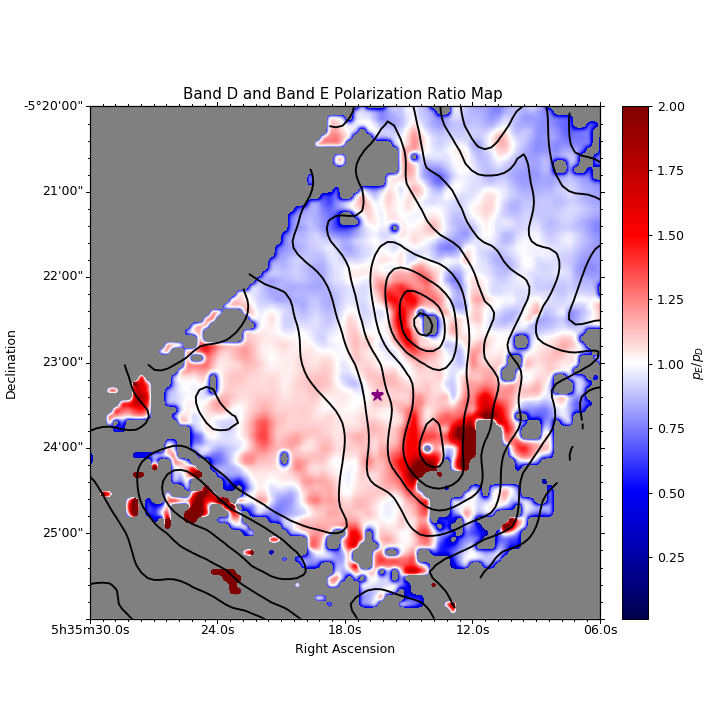

In [6]:
ratio2 = ratio.copy()
mask = np.where(abs(ang_d - ang_e) > 10)  # masking the area where difference of angle is greatr than 10.
ratio2[mask] = np.nan  # converting those areas in the ratio into nans
ratio2[np.isnan(ratio2)] = 0  # changing all the nans into zero. I needed to do this to make the map look
                              # smoother. 

# defining the axes labels and coordinates to plot the colormap
plt.figure(figsize=(8, 8))
ax=plt.axes(projection = w)
ra=ax.coords[0]
dec= ax.coords[1]
ra.display_minor_ticks(True)
dec.display_minor_ticks(True)
ra.set_minor_frequency(10)
ra.set_major_formatter('hh:mm:ss.s')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title('Band D and Band E Polarization Ratio Map ')
lowerleft= SkyCoord("5h35m30s -5d26m00s")
upperright=SkyCoord("5h35m06s -5d20m00s")
lx,ly=w.wcs_world2pix(lowerleft.ra.deg,lowerleft.dec.deg,0)
ux,uy=w.wcs_world2pix(upperright.ra.deg,upperright.dec.deg,0)
ax.set_xlim(lx,ux)
ax.set_ylim(ly,uy)

# plotting the contours for the intensity of band D
plt.contour(i_d1, levels = np.logspace(0, 2.8, 12), colors = "black") 

# To take care of the nans, which are now converted into 0. I converted them to different color gray
# so that they won't create confusion in the colormap.
cmap=plt.cm.seismic
cmap.set_under('gray', 1.)  # Set color to be used for low out-of-range values.

# plotting the colormap for the ratio. I set the minuimum to 0.009 so that anything below that will be gray
im = ax.imshow(ratio2, origin='lower',
           interpolation='gaussian',
           cmap=plt.cm.seismic,
           alpha = 1., vmin = 0.009, vmax = 2.)  

# plotting a Star in the Trapezium Cluster region
coord_star = SkyCoord("5h35m16.5s-5d23m22.8s")
x, y=w.wcs_world2pix(coord_star.ra.deg,coord_star.dec.deg,0)
plt.plot(x, y,  marker = "*", markersize = 10.0, color = "purple")

#plotting the colorbar for the ratio
plt.colorbar(im, fraction=0.046, pad=0.04, label = "$p_E/p_D$")
plt.show()
plt.savefig("PE_PD_contour_stage3.png")